### Lab Machine Learning, part one: Heart disease prediction.
[Link Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)  
About the dataset:  
Data description  
There are 3 types of input features:  

- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.
Features:  
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
- All of the dataset values were collected at the moment of medical examination.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/cardio_train.csv', delimiter=";")

#### EDA

In [2]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Examining the data, there is obviously some unrealistic data within it.
- Blood pressure: quite a lot of blood pressure metrics are unrealistic. Google search results in some knowledge on what values that are realistic to expect [Link to heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)
- Weight: there is some unrealistically low wight observations. Hard to draw a line but questimation is that values below 40kg can be removed.
- Height: mesures below 120cm and above 220cm removed. Obviously it's possible to be both taller and smaller, but this seems reasinable.

<Axes: ylabel='ap_hi'>

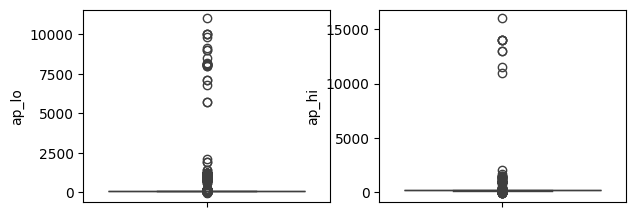

In [98]:
fig, ax = plt.subplots(1,2, figsize=(7, 2.5))
sns.boxplot(data = df, y = 'ap_lo', ax=ax[0])
sns.boxplot(data = df, y = 'ap_hi', ax=ax[1])

In [111]:
# extracting "valid" data, based on above:
df = df[(df['ap_lo'] < 200) & (df['ap_lo'] > 40) & (df['ap_hi'] > 50) & (df['ap_hi'] < 220) & (df['weight'] > 40) & (df['height'] > 120) & (df['height'] < 220)]

In [112]:
len(df)

68461

<Axes: ylabel='ap_hi'>

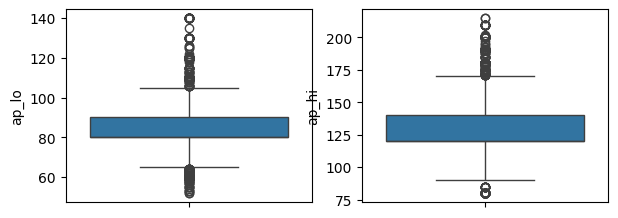

In [109]:
fig, ax = plt.subplots(1,2, figsize=(7, 2.5))
sns.boxplot(data = df, y = 'ap_lo', ax=ax[0])
sns.boxplot(data = df, y = 'ap_hi', ax=ax[1])

In [110]:
weight = df[df['weight']< 40]
weight

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs
3752,5306,15400,1,120,30.00,110,70,1,1,0,0,1,0,42.192
5794,8226,17663,1,151,37.00,120,80,1,1,0,0,1,0,48.392
10447,14908,22007,1,162,38.00,100,70,1,1,0,0,1,0,60.293
10627,15182,21669,1,153,37.00,150,80,3,3,0,0,1,1,59.367
11876,16963,17512,1,157,39.00,90,70,1,1,0,0,1,0,47.978
14722,21040,22663,1,143,34.00,100,70,1,1,0,0,1,0,62.090
16322,23318,21872,1,165,35.00,100,70,1,1,0,0,1,0,59.923
16906,24167,17272,2,170,31.00,150,90,2,2,0,0,1,1,47.321
18559,26503,18140,1,160,30.00,120,80,1,1,0,0,1,1,49.699
19582,27965,21334,1,152,38.00,110,80,1,1,0,0,1,0,58.449


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68659 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68659 non-null  int64  
 1   age          68659 non-null  int64  
 2   gender       68659 non-null  int64  
 3   height       68659 non-null  int64  
 4   weight       68659 non-null  float64
 5   ap_hi        68659 non-null  int64  
 6   ap_lo        68659 non-null  int64  
 7   cholesterol  68659 non-null  int64  
 8   gluc         68659 non-null  int64  
 9   smoke        68659 non-null  int64  
 10  alco         68659 non-null  int64  
 11  active       68659 non-null  int64  
 12  cardio       68659 non-null  int64  
 13  age_yrs      68659 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 7.9 MB


In [102]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs
count,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000
mean,49977.410696,19465.680785,1.348913,164.366638,74.132098,126.647927,81.380154,1.364672,1.225870,0.088000,0.053525,0.803376,0.494997,53.330632
std,28846.485289,2467.598696,0.476630,8.184331,14.326325,16.699586,9.458950,0.678970,0.571865,0.283297,0.225080,0.397448,0.499979,6.760544
min,0.000000,10798.000000,1.000000,55.000000,11.000000,80.000000,52.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.584000
25%,25004.500000,17660.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.384000
50%,50012.000000,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.978000
75%,74877.500000,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.422000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,240.000000,140.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.967000


1a: Number of individuals with presence and absence of cardiovascular disease.

In [14]:
cardio = df['cardio'].value_counts()
print(f'Nbr of individuels with absence of cardiovascular disease: {cardio.loc[0]}')
print(f'Nbr of individuels with presence of cardiovascular disease: {cardio.loc[1]}')

Nbr of individuels with absence of cardiovascular disease: 35021
Nbr of individuels with presence of cardiovascular disease: 34979


1b: Ratio of individuals with normal, above normal and well above normal cholesterol levels.

In [86]:
cholesterol_ratio = df['cholesterol'].value_counts()
cholesterol_ratio = cholesterol_ratio.to_frame()
cholesterol_ratio['cholesterol_ratio'] = cholesterol_ratio['count'] / cholesterol_ratio['count'].sum()
print(f'Ratio of individuals with "normal" cholesterol levels: {cholesterol_ratio.iloc[0,1]:.1%} percent')
print(f'Ratio of individuals with "above normal" cholesterol levels: {cholesterol_ratio.iloc[1,1]:.1%} percent')
print(f'Ratio of individuals with "well above normal" cholesterol levels: {cholesterol_ratio.iloc[2,1]:.1%} percent')


Ratio of individuals with "normal" cholesterol levels: 74.8% percent
Ratio of individuals with "above normal" cholesterol levels: 13.6% percent
Ratio of individuals with "well above normal" cholesterol levels: 11.5% percent


1c: Age distribution:

Text(0.5, 0, 'Age interval [years]')

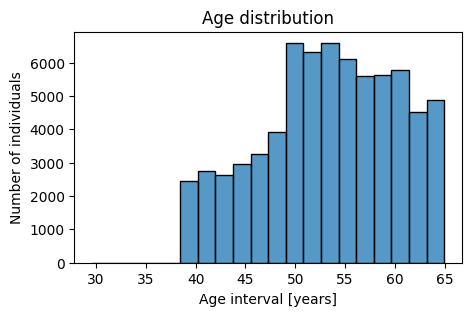

In [81]:
df['age_yrs'] = round(df['age']/365, 3)
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(data = df, x='age_yrs', bins=20)
plt.title('Age distribution')
plt.ylabel('Number of individuals')
plt.xlabel('Age interval [years]')

1d: Ratio of smokers

In [85]:
ratio_smokers = df['smoke'][df['smoke'] == 1].sum() / len(df['smoke'])
print(f"Ratio of individuals that smoke: {ratio_smokers:.2%}")


Ratio of individuals that smoke: 8.81%


1e: Weight distribution

In [87]:
df['weight'].describe()

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64